In [1]:
from PIL import Image, ImageDraw
#import numpy as np
import math
import os
from datetime import datetime
from numpy.random import random

%load_ext memory_profiler

In [2]:
# Поиск ближашей точки
# по развертывающимуся квадрату (в пределах 30) и возвращение дистанции
def box(ox, oy, image):
    pix = image.load() 
    distance = 0
    try:
        for limit in range(1, 31):
            x = ox + limit
            y = oy + limit
            for ix in range(limit*2+1):
                x = x - 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            for iy in range(limit*2+1):
                y = y - 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            for jx in range(limit*2+1):
                x = x + 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            for jy in range(limit*2+1):
                y = y + 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            if distance > 0:
                return(distance)
    except IndexError:
        pass
    return(distance)

In [3]:
# Генератор точек с вероятностью 0.002 с параметрос n
def generatorJPG(image, n = 1, area = 4):
    if area > 10 or area < 1:
        return('Error area in range 1 to 10')
    imagetemp = image
    width  = area * image.size[0] // 10
    height = area * image.size[1] // 10
    draw = ImageDraw.Draw(imagetemp)
    for x in range(width):
        for y in range(height):
                if x**2+y**2 < width**2 and random() < n*0.002:
                    draw.point((x,y), (0,0,0))            
    return(imagetemp)

In [4]:
#  Разбиение плоскости на n=1 область лучами
#  Сбор данных с областей: 
# количество точек, минмальная\максимальная\средняя дистанции
def sun(image, n = 2, area = 4):
    imagetemp = image
    
    if area<1 or area >10:
        return('Error area in range from 1 to 10')
    width  = area*image.size[0]//10
    height = area*image.size[1]//10
    
    partition = [0]*(4*(n+1)) # хранилище статистики
    
    draw = ImageDraw.Draw(imagetemp)
    
    # сканирование начальной области
    for x in range(width//2):
        for y in range(height//2):
            if pix[x,y] == (0,0,0): #проверка точки
                # сбор данных
                distance = box(x,y,image)#дистанция
                # классификация на области
                for c in range(n+1):
                    if (y+1)/(x+1) > math.tan((c*math.pi)/(2*(n+1))):
                        partition[4*c] = partition[4*c] + 1
                        # минимум
                        if partition[4*c+1] > distance or partition[4*c+1] == 0:
                            partition[4*c+1] = distance
                        # максимум
                        if partition[4*c+2] < distance:
                            partition[4*c+2] = distance
                        partition[4*c+3] = partition[4*c+3] + distance # сложение дистанций
                        
                        
    # приведение данных для n+1 области
    for c in range(n):
        partition[4*c] = partition[4*c] - partition[4*(c+1)] # приведение к несовместности множеств точек
        try:
            partition[4*c+3] = partition[4*c+3] // partition[4*c] # усреднение квадратов дистанций
        except ZeroDivisionError:
            pass
    print(partition)
            
    for x in range(width+1):
        for y in range(height+1):
            if x**2+y**2 in range(height**2-height,height**2+height):
                draw.point((x,y), (255,0,0))
        
    # продление статистической модели на расширение каждой области
    for c in range(n+1):
        dis = math.sqrt(partition[4*c+2]) # чистый максимум
        director = math.tan(((c+0.5)*math.pi)/(2*(n+1))) # коррекция вдоль луча разбиения
        
        # метка на конце начальной области
        x = height * math.cos((c+0.5)*math.pi/(2*(n+1)))
        y = width  * math.sin((c+0.5)*math.pi/(2*(n+1)))
        # заполнение точками
        for count in range( int(partition[4*c]*(10*10/(area*area))) ):
            # функция рекурсивного подбора
            def random_shift(x,y,  c , n , partition , dis = 0):
                # итерация новой точки
                xy = [0 , 2*(0.5-random())*dis]
                xy = [x + 2*(0.5-random()) * math.sqrt(partition[4*c+2]-(xy[1]**2)), y + xy[1]*director]
                # условия принадлежности новой точки области
                if not (xy[0]**2 + xy[1]**2 > height**2 
                          and xy[1]/xy[0] > math.tan((  c  *math.pi)/(2*(n+1)))
                          and xy[1]/xy[0] < math.tan(((c+1)*math.pi)/(2*(n+1)))
                          and xy[0]**2 + xy[1]**2 > partition[4*c+1]):
                    xy = random_shift(x,y, c , n , partition , dis)
                # новая точка и коррекция следующей
                dis = dis * (2*math.sqrt(partition[4*c+3]) - math.sqrt(xy[0]**2+xy[1]**2)) / math.sqrt(xy[0]**2+xy[1]**2) # коррекция к среднему
                return(xy)
            xy = random_shift(x,y, c , n , partition , dis)
            x = xy[0] 
            y = xy[1]
            draw.point((xy[0],xy[1]), (0,0,0))             
    del draw            
    return(imagetemp)

[8, 13, 392, 400, 16, 18, 392, 154, 7, 45, 260, 750]
C:\Users\B150M-C\JupyterProject\Machine learning\images\D03022021 18 04.jpg
peak memory: 63.09 MiB, increment: 0.21 MiB


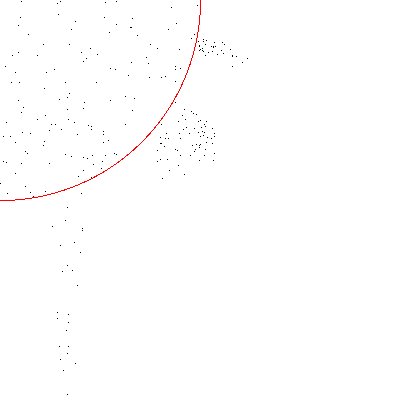

In [5]:
image = Image.new(mode='RGB', size=(400,400),color=(255,255,255))

draw = ImageDraw.Draw(image)
pix = image.load()

image = generatorJPG(image, 2, 5)
image = sun(image, 2, 5)
time = datetime.now().strftime("%d%m%Y %H %M") + '.jpg'
directory = os.getcwd() + '\\images\\D' + time

print(directory)
del draw
image.save(directory)

%memit
image